# analysis_prelim_p17c.ipynb

## Purpose
Preliminary analysis of CESM simulation output from project [p17c-marc-comparison](https://github.com/grandey/p17c-marc-comparison).

## Requirements
- Post-processed CESM output from [cdo_analysis_prelim_p17c.sh](https://github.com/grandey/p17c-marc-comparison/blob/master/analysis_prelim/cdo_analysis_prelim_p17c.sh).
- Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy).

## Author
Benjamin S. Grandey, 2017

In [1]:
import climapy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import scipy
from scipy import stats
import xarray as xr

# Print versions of packages
for module in [climapy, np, scipy, xr]:
    try:
        print('{}.__version__ = {}'.format(module.__name__, module.__version__))
    except AttributeError:
        pass

%matplotlib inline
matplotlib.rcParams['figure.dpi']= 40  # reduce resolution of inline figures to reduce notebook size

climapy.__version__ = 0.0.1+0597060
numpy.__version__ = 1.13.1
scipy.__version__ = 0.19.1
xarray.__version__ = 0.9.6


## Post-processed data file location
Location of files written by [cdo_analysis_prelim_p17c.sh](https://github.com/grandey/p17c-marc-comparison/blob/master/analysis_prelim/cdo_analysis_prelim_p17c.sh), including annual means for years 3-32.

In [2]:
in_dir = os.path.expandvars('$HOME/data/projects/p17c_marc_comparison/cdo_analysis_prelim/')

## Function to produce zonal mean line plot
- Put latitude on y-axis for consistency with maps
- If 3D field, use surface data

In [3]:
def zonal_mean_line_plot(year='2000', model_var_dict={'mam3': 'BURDENPOM'},
                         sf=None, xlabel=None, xlim=None,
                         ylabel=True, 
                         title=None,
                         ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # Loop over model-variable combinations
    for model, var_name in model_var_dict.items():
        # Color based on model
        if model == 'marc':
            c = 'r'
            alpha = 1
            linestyle = '-'
        elif model == 'mam3':
            c = 'g'
            alpha = 0.75
            linestyle = '--'
        elif model == 'mam7':
            c = 'b'
            alpha = 0.5
            linestyle = ':'
        # Case 1: single year (1850 or 2000)
        if year in ['1850', '2000']:
            # Load annual mean data
            in_filename = '{}/s1.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, year, var_name)
            data = xr.open_dataset(in_filename, decode_times=False)
            data = climapy.cesm_time_from_bnds(data)  # populate time dimension using climapy
            # Calculate zonal mean
            zm = data.mean(dim='lon')
            # If 3D field, get data for surface
            if 'lev' in zm.dims:
                zm = zm.isel(lev=-1)
            # Plot line - showing mean across time
            tm = zm.mean(dim='time')[var_name].data.flatten() * sf
            ax.plot(tm, zm['lat'].data,
                    c=c, alpha=alpha, linestyle=linestyle,
                    label=model.upper())
            # Plot shading - based on standard error
            error = zm.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm['time'].size) * sf
            ax.fill_betweenx(zm['lat'].data, tm-error, tm+error,
                             facecolor=c, alpha=0.2)
            # Close dataset
            data.close()
        # Case 2: difference (2000-1850)
        if year == '2000-1850':
            # Load annual mean data
            in_filename1 = '{}/s2.zm.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '2000', var_name)
            data1 = xr.open_dataset(in_filename1, decode_times=False)
            data1 = climapy.cesm_time_from_bnds(data1)
            in_filename2 = '{}/s2.zm.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '1850', var_name)
            data2 = xr.open_dataset(in_filename2, decode_times=False)
            data2 = climapy.cesm_time_from_bnds(data2)
            # Calculate zonal means
            zm1 = data1.mean(dim='lon')
            zm2 = data2.mean(dim='lon')
            # If 3D field, get data for surface
            if 'lev' in zm1.dims:
                zm1 = zm1.isel(lev=-1)
                zm2 = zm2.isel(lev=-1)
            # Plot line - showing difference of means across time
            tm1 = zm1.mean(dim='time')[var_name].data.flatten() * sf
            tm2 = zm2.mean(dim='time')[var_name].data.flatten() * sf
            tm = tm1 - tm2
            ax.plot(tm, zm1['lat'].data,
                    c=c, alpha=alpha, linestyle=linestyle,
                    label=model.upper())
            # Plot shading - based on combined standard error
            error1 = zm1.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm1['time'].size) * sf
            error2 = zm2.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(zm2['time'].size) * sf
            error = np.sqrt(error1**2 + error2**2)
            ax.fill_betweenx(zm1['lat'].data, tm-error, tm+error,
                             facecolor=c, alpha=0.2)
            # Close datasets
            data1.close()
            data2.close()
    # Lines showing zero
    ax.axhline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    ax.axvline(0, c='k', alpha=0.2, linewidth=1, linestyle='--')
    # y-axis
    ax.set_ylim([-90, 90])
    ax.set_yticks(np.arange(-90, 91, 30))
    if ylabel:
        ax.set_ylabel(r'Latitude, $^\circ$N', fontsize='large')
    # x-axis
    if xlabel:
        ax.set_xlabel(xlabel, fontsize='large')
    if xlim:
        ax.set_xlim(xlim)
    # Title and legend
    if title:
        ax.set_title(title, fontsize='large')
    ax.legend()
    return ax

# Examples
if False:
    # Example 1
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True, sharex=True)
    for year, ylabel, title, ax in zip(['1850', '2000'], [True, False], ['(a) Year-1850', '(b) Year-2000'], axs):
        zonal_mean_line_plot(year=year, model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'},
                             sf=1e6, xlabel=r'BC column burden, mg m$^{-2}$', xlim=[0, 0.35],
                             ylabel=ylabel, title=title, ax=ax)
    # Example 2
    ax = zonal_mean_line_plot(year='2000-1850', model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'},
                              xlabel=r'Net RFP, W m$^{-2}$')

## Zonal means of column burdens
- 2 columns: year-1850, year-2000
- 5 rows: pure sulphate, OC, BC, MOS, MBS
- 1-3 lines per panel (showing different models)

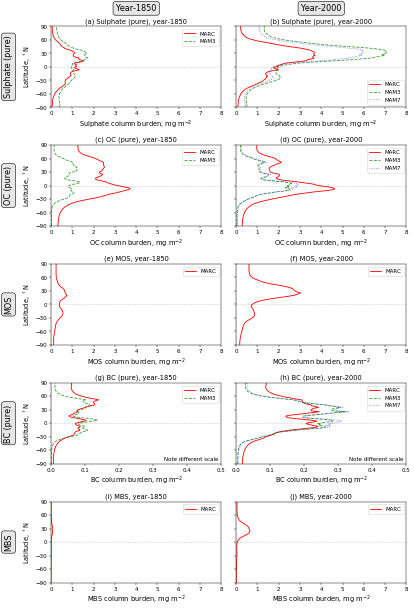

In [4]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True, sharex=False)
# Loop over species (rows)
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    # Information for different species
    sf=1e6
    xlim=[0, 8]  # all except BC
    if species == 'Sulphate (pure)':
        model_var_dict={'marc': 'pSUL_LDG', 'mam3': 'BURDENSO4'}
        xlabel='Sulphate column burden, mg m$^{-2}$'
    elif species == 'OC (pure)':
        model_var_dict={'marc': 'OC_LDG', 'mam3': 'BURDENPOM'}
        xlabel='OC column burden, mg m$^{-2}$'
    elif species == 'BC (pure)':
        model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'}
        xlabel='BC column burden, mg m$^{-2}$'
        xlim=[0, 0.5]
    elif species == 'MOS':
        model_var_dict={'marc': 'MOS_LDG'}
        xlabel='MOS column burden, mg m$^{-2}$'
    elif species == 'MBS':
        model_var_dict={'marc': 'MBS_LDG'}
        xlabel='MBS column burden, mg m$^{-2}$'
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000'), range(2)):
        # If year-2000, include MAM7
        if year == '2000' and species not in ['MOS', 'MBS']:
            model_var_dict['mam7'] = model_var_dict['mam3']
        # Title
        title = '({}) {}, year-{}'.format(chr(97+c+r*2), species, year)
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        else:
            ylabel = False
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row and column titles
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.25 * xlim[1]
    axs[r, 0].text(xpos, 0, species,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
for year, c in zip(('1850', '2000'), range(2)):
    axs[0, c].text(4, 130, 'Year-{}'.format(year),
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Other annotation
for c in range(2):
    axs[3, c].text(0.49, -85, 'Note different scale',
                   verticalalignment='bottom', horizontalalignment='right')
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/burden_zonal_means.pdf', bbox_inches='tight', dpi=150)

**Zonal means of column burdens, with 2000-1850 differences**
- 3 columns: year-1850, year-2000, 2000-1850
- 5 rows: pure sulphate, OC, BC, MOS, MBS
- 1-3 lines per panel (showing different models)

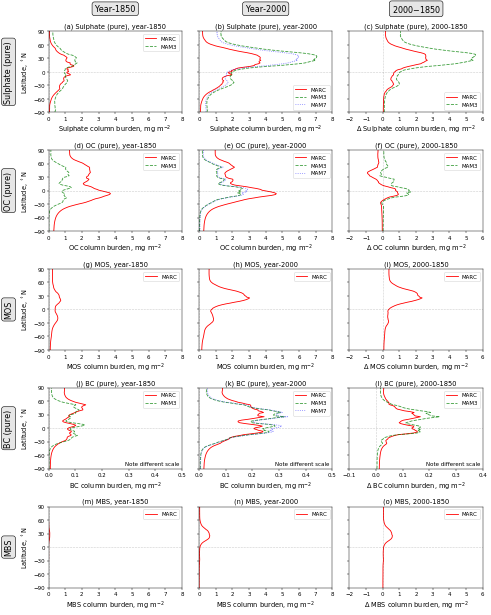

In [5]:
fig, axs = plt.subplots(5, 3, figsize=(12, 15), sharey=True, sharex=False)
# Loop over species (rows)
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000', '2000-1850'), range(3)):
        # Information for different species
        if species == 'Sulphate (pure)':
            model_var_dict={'marc': 'pSUL_LDG', 'mam3': 'BURDENSO4'}
            xlabel='Sulphate column burden, mg m$^{-2}$'
        elif species == 'OC (pure)':
            model_var_dict={'marc': 'OC_LDG', 'mam3': 'BURDENPOM'}
            xlabel='OC column burden, mg m$^{-2}$'
        elif species == 'BC (pure)':
            model_var_dict={'marc': 'BC_LDG', 'mam3': 'BURDENBC'}
            xlabel='BC column burden, mg m$^{-2}$'
            xlim=[0, 0.5]
        elif species == 'MOS':
            model_var_dict={'marc': 'MOS_LDG'}
            xlabel='MOS column burden, mg m$^{-2}$'
        elif species == 'MBS':
            model_var_dict={'marc': 'MBS_LDG'}
            xlabel='MBS column burden, mg m$^{-2}$'
        # If year-2000, include MAM7
        if year == '2000' and species not in ['MOS', 'MBS']:
            model_var_dict['mam7'] = model_var_dict['mam3']
        # If 2000-1850 difference, exclude MAM7 and add delta to xlabel
        elif year == '2000-1850':
            try:
                del model_var_dict['mam7']
            except KeyError:
                pass
            xlabel = r'$\Delta$ ' + xlabel
        # x-axis range and scale factor
        sf=1e6
        if species == 'BC (pure)':
            if year == '2000-1850':
                xlim = [-0.1, 0.4]
            else:
                xlim = [0, 0.5]
        else:
            if year == '2000-1850':
                xlim = [-2, 6]
            else:
                xlim = [0, 8]
        # Title
        if year == '2000-1850':
            title = '({}) {}, {}'.format(chr(97+c+r*3), species, year)
        else:
            title = '({}) {}, year-{}'.format(chr(97+c+r*3), species, year)
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        else:
            ylabel = False
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row titles
for species, r in zip(('Sulphate (pure)', 'OC (pure)', 'MOS', 'BC (pure)', 'MBS'), range(5)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.3 * xlim[1]
    axs[r, 0].text(xpos, 0, species,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
# Column titles
for year, c in zip(('Year-1850', 'Year-2000', r'2000$-$1850'), range(3)):
    xlim = axs[0, c].get_xlim()
    xpos = np.mean(xlim)
    axs[0, c].text(xpos, 140, year,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Other annotation
for c in range(3):
    xlim = axs[3, c].get_xlim()
    xpos = xlim[1] - 0.01
    axs[3, c].text(xpos, -85, 'Note different scale',
                   verticalalignment='bottom', horizontalalignment='right')
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/burden_zonal_means2.pdf', bbox_inches='tight', dpi=150)
fig.savefig('local/burden_zonal_means2.png', bbox_inches='tight', dpi=600)

## Zonal means of surface CCN
- 2 columns: year-1850, year-2000
- 1 row: CCN3
- 2-3 lines per panel (showing different models)

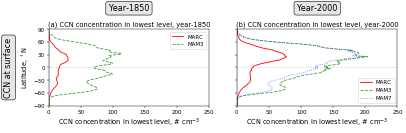

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=False)
var_name = 'CCN3'
var_long = 'CCN concentration in lowest level'
xlabel = var_long + r', # cm$^{-3}$'
sf = 1
xlim = (0, 250)
model_var_dict={'marc': var_name, 'mam3': var_name}    
# Loop over years (columns)    
for year, c in zip(('1850', '2000'), range(2)):
    # If year-1850, include ylabel
    if year == '1850':
        ylabel = True
    # If year-2000, include MAM7
    else:
        model_var_dict['mam7'] = var_name
        ylabel = False
    # Title
    title = '({}) {}, year-{}'.format(chr(97+c), var_long, year)
    # Plot panel
    zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                         sf=sf, xlabel=xlabel, xlim=xlim,
                         ylabel=ylabel, title=title, ax=axs[c])
# Row title
xlim = axs[0].get_xlim()
xpos = -0.25 * xlim[1]
axs[0].text(xpos, 0, 'CCN at surface',
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            rotation=90,
            bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
# Column titles
for year, c in zip(('1850', '2000'), range(2)):
    xlim = axs[c].get_xlim()
    xpos = np.mean(xlim)
    axs[c].text(xpos, 140, 'Year-{}'.format(year),
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/ccn_surface_zonal_means.pdf', bbox_inches='tight', dpi=150)

**Zonal means of surface CCN, with 2000-1850 differences**
- 3 columns: year-1850, year-2000, 2000-1850
- 1 row: CCN3
- 2-3 lines per panel (showing different models)

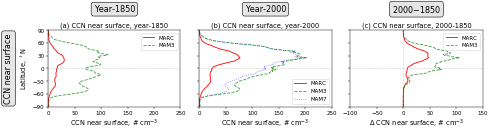

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=False)
var_name = 'CCN3'
var_long = 'CCN near surface'
xlabel = var_long + r', # cm$^{-3}$'
sf = 1
xlim = (0, 250)
model_var_dict={'marc': var_name, 'mam3': var_name}    
# Loop over years (columns)    
for year, c in zip(('1850', '2000', '2000-1850'), range(3)):
    # If year-1850, include ylabel
    if year == '1850':
        ylabel = True
    # If year-2000, include MAM7
    elif year == '2000':
        model_var_dict['mam7'] = var_name
        ylabel = False
    # If 2000-1850, exclude MAM7, add delta to xlabel, and change xlim
    else:
        del model_var_dict['mam7']
        xlabel = r'$\Delta$ ' + xlabel
        xlim = (-100, 150)
    # Title
    if year == '2000-1850':
        title = '({}) {}, {}'.format(chr(97+c), var_long, year)
    else:
        title = '({}) {}, year-{}'.format(chr(97+c), var_long, year)
    # Plot panel
    zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                         sf=sf, xlabel=xlabel, xlim=xlim,
                         ylabel=ylabel, title=title, ax=axs[c])
# Row title
xlim = axs[0].get_xlim()
xpos = -0.3 * xlim[1]
axs[0].text(xpos, 0, 'CCN near surface',
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            rotation=90,
            bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
# Column titles
for year, c in zip(('Year-1850', 'Year-2000', r'2000$-$1850'), range(3)):
    xlim = axs[c].get_xlim()
    xpos = np.mean(xlim)
    axs[c].text(xpos, 140, year,
                fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/ccn_surface_zonal_means2.pdf', bbox_inches='tight', dpi=150)
fig.savefig('local/ccn_surface_zonal_means2.png', bbox_inches='tight', dpi=600)

## Zonal means of cloud water path
- 2 columns: year-1850, year-2000
- 2 rows: liquid water path, ice water path
- 2-3 lines per panel (showing different models)

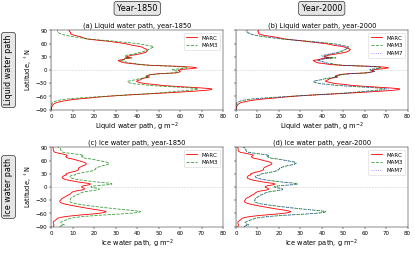

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), sharey=True, sharex=False)
# Loop over variables (rows)
for var_name, var_long, r in zip(['TGCLDLWP', 'TGCLDIWP'],
                               [r'Liquid water path', 'Ice water path'],
                               range(2)):
    xlabel = var_long + r', g m$^{-2}$'
    sf = 1e3
    xlim = [0, 80]
    model_var_dict={'marc': var_name, 'mam3': var_name}    
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000'), range(2)):
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        # If year-2000, include MAM7
        else:
            model_var_dict['mam7'] = var_name
            ylabel = False
        # Title
        title = '({}) {}, year-{}'.format(chr(97+c+r*2), var_long, year)
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row and column titles
for var_long, r in zip(['Liquid water path', 'Ice water path'], range(2)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.25 * xlim[1]
    axs[r, 0].text(xpos, 0, var_long,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
for year, c in zip(('1850', '2000'), range(2)):
    xlim = axs[r, 0].get_xlim()
    xpos = np.mean(xlim)
    axs[0, c].text(xpos, 140, 'Year-{}'.format(year),
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/water_path_zonal_means.pdf', bbox_inches='tight', dpi=150)

**Zonal means of cloud water path, with 2000-1850 differences**
- 3 columns: year-1850, year-2000, 2000-1850
- 2 rows: liquid water path, ice water path
- 2-3 lines per panel (showing different models)

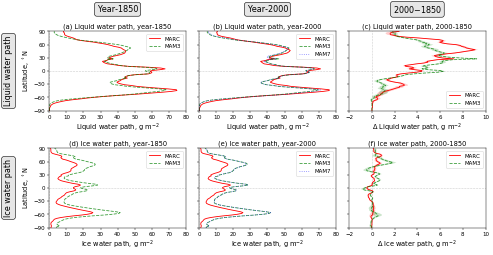

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=False)
# Loop over variables (rows)
for var_name, var_long, r in zip(['TGCLDLWP', 'TGCLDIWP'],
                                 [r'Liquid water path', 'Ice water path'],
                                 range(2)):
    xlabel = var_long + r', g m$^{-2}$'
    sf = 1e3
    xlim = [0, 80]
    model_var_dict={'marc': var_name, 'mam3': var_name}    
    # Loop over years (columns)    
    for year, c in zip(('1850', '2000', '2000-1850'), range(3)):
        # If year-1850, include ylabel
        if year == '1850':
            ylabel = True
        # If year-2000, include MAM7
        elif year == '2000':
            model_var_dict['mam7'] = var_name
            ylabel = False
        # If 2000-1850, exclude MAM7, add delta to xlabel, and modify xlim
        else:
            del model_var_dict['mam7']
            xlabel = '$\Delta$ ' + xlabel
            xlim = [-2, 10]
        # Title
        if year == '2000-1850':
            title = '({}) {}, {}'.format(chr(97+r*3+c), var_long, year)
        else:
            title = '({}) {}, year-{}'.format(chr(97+r*3+c), var_long, year)
        # Plot panel
        zonal_mean_line_plot(year=year, model_var_dict=model_var_dict,
                             sf=sf, xlabel=xlabel, xlim=xlim,
                             ylabel=ylabel, title=title, ax=axs[r, c])
# Row titles
for var_long, r in zip(['Liquid water path', 'Ice water path'], range(2)):
    xlim = axs[r, 0].get_xlim()
    xpos = -0.3 * xlim[1]
    axs[r, 0].text(xpos, 0, var_long,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   rotation=90,
                   bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
# Column titles
for year, c in zip(('Year-1850', 'Year-2000', '2000$-$1850'), range(3)):
    xlim = axs[0, c].get_xlim()
    xpos = np.mean(xlim)
    axs[0, c].text(xpos, 140, year,
                   fontsize='x-large', verticalalignment='center', horizontalalignment='center',
                   bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/water_path_zonal_means2.pdf', bbox_inches='tight', dpi=150)
fig.savefig('local/water_path_zonal_means2.png', bbox_inches='tight', dpi=600)

## Zonal means of TOA RFP components
- 5 panels: surface albedo, direct effect, SW cloud, LW cloud, net
- Arrange panels in three rows of two columns
- 2 lines for panel (showing different models)

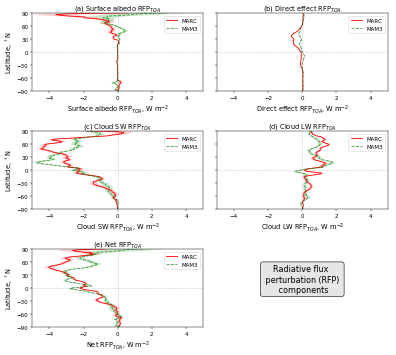

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(10, 9), sharey=True, sharex=False)
# Loop over RFP components (panels)
for var_long, p, ax in zip(['Surface albedo', 'Direct effect', 'Cloud SW', 'Cloud LW', 'Net'],
                           range(5), axs.flatten()):
    # Information for different components
    sf = 1
    xlim = [-5, 5]
    xlabel = '{} RFP$_{{TOA}}$, W m$^{{-2}}$'.format(var_long)
    if var_long == 'Surface albedo':
        model_var_dict={'marc': 'FSNTOACNOA', 'mam3': 'FSNTOAC_d1'}
    elif var_long == 'Direct effect':
        model_var_dict={'marc': 'cDRE', 'mam3': 'cDRE'}
    elif var_long == 'Cloud SW':
        model_var_dict={'marc': 'CRF', 'mam3': 'SWCF_d1'}
    elif var_long == 'Cloud LW':  # Using LWCF, since clean-sky LWCF is not available for MARC
        model_var_dict={'marc': 'LWCF', 'mam3': 'LWCF'}
    elif var_long == 'Net':
        model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'}
    # If lefthand column, include ylabel
    if p in [0, 2, 4]:
        ylabel = True
    else:
        ylabel = False
    # Title
    title = '({}) {} RFP$_{{TOA}}$'.format(chr(97+p), var_long)
    # Plot panel
    zonal_mean_line_plot(year='2000-1850', model_var_dict=model_var_dict,
                         sf=sf, xlabel=xlabel, xlim=xlim,
                         ylabel=ylabel, title=title, ax=ax)
# Hide final subplot
axs[-1, -1].axis('off')
# Add figure title below 4th panel
axs[1, 1].text(0, -250, 'Radiative flux \n perturbation (RFP) \n components',
               fontsize='x-large', verticalalignment='center', horizontalalignment='center',
               bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/rfp_zonal_means.pdf', bbox_inches='tight', dpi=150)

## Function to produce map of differences

In [11]:
def difference_map(year='2000-1850', model='marc', var_name='cFNTOA',
                   sf=None, vmin=-6, vmax=6, whiteout='0.0', cmap=None,
                   title=None,
                   ax=None):
    # Case 1: 2000-1850 difference
    if year == '2000-1850':
        in_filename_list = ['{}/s1.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '2000', var_name),
                            '{}/s1.ym.p17c_{}_{}.cam.h0.{}.nc'.format(in_dir, model, '1850', var_name)]
    else:
        print('Currently only 2000-1850 differences are implemented.')
        return -1
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # If no scale-factor specified, set as 1
    if sf is None:
        sf = 1
    # If no cmap specified, create one
    if cmap is None:
        cmap = plt.cm.get_cmap('RdBu_r', 12)
        cmap.set_under([0, 0, 0.25])
        cmap.set_over([0.25, 0, 0])
    # Load data
    data_list = []
    for in_filename in in_filename_list:
        data = xr.open_dataset(in_filename, decode_times=False) * sf
        data = climapy.xr_shift_lon(data, lon_min=-180.)  # shift longitudes by approx -180deg
        data_list.append(data)
    # Calculate means across time
    tm_list = []
    for data in data_list:
        tm = data.mean(dim='time')[var_name].data
        tm_list.append(tm)
    tm_diff = tm_list[0] - tm_list[1]  # difference
    # Find where statistically significant and larger than whiteout value
    p_values = stats.ttest_ind(data_list[0][var_name].data,
                               data_list[1][var_name].data,
                               equal_var=False)[1]  # Welch's t-test
    p_fdr = climapy.stats_fdr(p_values, alpha=0.05)  # p-value threshold
    w_sig = np.where((p_values.ravel() <= p_fdr) & (np.abs(tm_diff.ravel()) > float(whiteout)))
    lon_sig, lat_sig = np.meshgrid(data_list[0]['lon'].data, data_list[1]['lat'].data)
    lon_sig = lon_sig.ravel()[w_sig]
    lat_sig = lat_sig.ravel()[w_sig]
    # Lower bound for first longitude bin (important for map)
    lon0 = (data['lon'][0] - (data['lon'][1]-data['lon'][0])/2.0).data
    # Pseudo-lower bound for first latitude bin (used for stretching imshow)
    lat0 = (data['lat'][0] - (data['lat'][1]-data['lat'][0])/2.0).data
    # Map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(ax=ax)
    # Plot field and stippling
    im = ax.imshow(np.ma.masked_inside(tm_diff, -1*float(whiteout), float(whiteout)),
                   extent=[lon0, 360+lon0, -lat0, lat0],
                   vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto')
    ax.scatter(lon_sig, lat_sig, marker='.', s=0.05, c='k')
    # Annotate with p-value threshold
    ax.text(-180, -105, r'$p_{{FDR}}\approx{:.3f}$'.format(p_fdr),
            color='0.5', horizontalalignment='left', verticalalignment='center')
    # Annotate with area-weighted mean
    mean_list = []  # list to hold area-weighted means
    error_list = []  # list to hold standard errors on means
    for data in data_list:
        awm = climapy.xr_area_weighted_stat(data)
        mean_list.append(awm.mean(dim='time')[var_name].data)
        error = awm.std(dim='time', ddof=1)[var_name].data.flatten() / np.sqrt(awm['time'].size)
        error_list.append(error)
    mean_diff = mean_list[0] - mean_list[1]
    error = float(np.sqrt(error_list[0]**2 + error_list[1]**2))
    ax.text(180, -105, 'Mean$={:+.3f}\pm{:.3f}$'.format(mean_diff, error),
            color='k', horizontalalignment='right', verticalalignment='center')
    # Close datasets
    for data in data_list:
        data.close()
    # Title
    if title:
        ax.set_title(title, fontsize='large')
    return ax, im, tm_diff

# Examples
if False:
    # Example 1
    fig = plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[4, 1], width_ratios=[2, 3, 3])
    zonal_mean_line_plot(year='2000-1850', model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'},
                         sf=None, xlabel=r'Net RFP, W m$^{-2}$', xlim=[-6, 6],
                         ylabel=True, title='(a) Net RFP', ax=plt.subplot(gs[0, 0]))
    ax, im, tm_diff1 = difference_map(year='2000-1850', model='marc', var_name='cFNTOA', vmin=-6, vmax=6,
                                     title='(b) MARC, Net RFP', ax=plt.subplot(gs[0, 1]))
    ax, im, tm_diff2 = difference_map(year='2000-1850', model='mam3', var_name='cFNTOA', vmin=-6, vmax=6,
                                     title='(c) MAM3, Net RFP', ax=plt.subplot(gs[0, 2]))
    if max(tm_diff1.max(), tm_diff2.max()) > 6 and min(tm_diff1.min(), tm_diff2.min()) < -6:
        extend = 'both'
    elif max(tm_diff1.max(), tm_diff2.max()) > 6:
        extend = 'max'
    elif min(tm_diff1.min(), tm_diff2.min()) < -6:
        extend = 'min'
    else:
        extend = False
    fig.colorbar(im, cax=plt.subplot(gs[1, 1:]), orientation='horizontal', extend=extend)
    fig.tight_layout()

## TOA RFP composite showing zonal means and maps
- 3 columns: zonal means, MARC map, MAM3 map
- 5 rows: surface albedo, direct effect, SW cloud, LW cloud, net

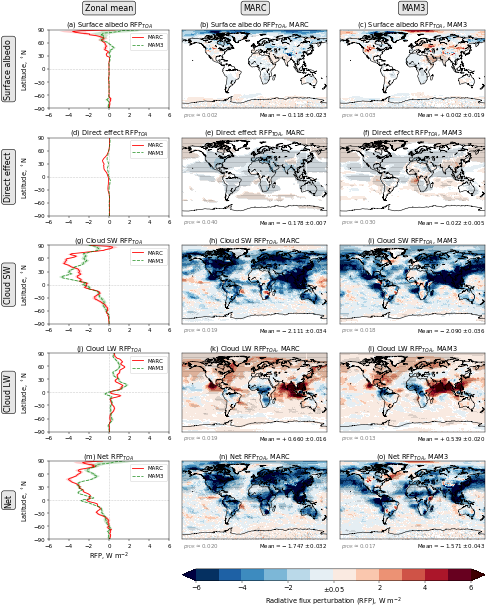

In [12]:
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(6, 3,  # 6th row is for colorbar
                       height_ratios=[1, 1, 1, 1, 1, 0.15], width_ratios=[2.5, 3, 3])
axs = []  # list to hold axes
tm_diff_list = []  # list to hold difference fields from maps - for colorbar extension choice
xlim = [-6, 6]  # x-axis and colorbar range
whiteout = '0.05'  # mask values with small magnitude
xticks = np.arange(-6, 7, 2)
# Loop over variables (rows)
for var_long, r in zip(['Surface albedo', 'Direct effect', 'Cloud SW', 'Cloud LW', 'Net'], range(5)):
    # Variable names for different components
    if var_long == 'Surface albedo':
        model_var_dict={'marc': 'FSNTOACNOA', 'mam3': 'FSNTOAC_d1'}
    elif var_long == 'Direct effect':
        model_var_dict={'marc': 'cDRE', 'mam3': 'cDRE'}
    elif var_long == 'Cloud SW':
        model_var_dict={'marc': 'CRF', 'mam3': 'SWCF_d1'}
    elif var_long == 'Cloud LW':  # Using LWCF, since clean-sky LWCF is not available for MARC
        model_var_dict={'marc': 'LWCF', 'mam3': 'LWCF'}
    elif var_long == 'Net':
        model_var_dict={'marc': 'cFNTOA', 'mam3': 'cFNTOA'}
    # 1st column: zonal means
    ax = plt.subplot(gs[r, 0])
    axs.append(ax)
    if r == 4:  # add x-axis label to only final row
        xlabel = r'RFP, W m$^{-2}$'
    else:
        xlabel = None
    title = '({}) {} RFP$_{{TOA}}$'.format(chr(97+r*3), var_long)
    zonal_mean_line_plot(year='2000-1850', model_var_dict=model_var_dict,
                         xlabel=xlabel, xlim=xlim,
                         ylabel=True, title=title, ax=ax)
    plt.xticks(xticks)
    # Row title
    ax.text(-10, 0, var_long,
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            rotation=90,
            bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
    # 2nd & 3rd columns: maps
    for model, c in zip(['marc', 'mam3'], range(1, 3)):
        ax = plt.subplot(gs[r, c])
        axs.append(ax)
        title = '({}) {} RFP$_{{TOA}}$, {}'.format(chr(97+r*3+c), var_long, model.upper())
        ax, im, tm_diff = difference_map(year='2000-1850', model=model, var_name=model_var_dict[model],
                                         vmin=xlim[0], vmax=xlim[1], whiteout=whiteout,
                                         title=title, ax=ax)
        tm_diff_list.append(tm_diff)
# Colorbar
tm_diff_max = max([tm_diff.max() for tm_diff in tm_diff_list])
tm_diff_min = min([tm_diff.min() for tm_diff in tm_diff_list])
if tm_diff_min < xlim[0] and tm_diff_max > xlim[1]:
    extend = 'both'
elif tm_diff_min < xlim[0]:
    extend = 'min'
elif tm_diff_max > xlim[1]:
    extend = 'max'
else:
    extend = 'neither'
cbar = fig.colorbar(im, cax=plt.subplot(gs[5, 1:]), orientation='horizontal',
                    ticks=xticks, extend=extend)
tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
tick_labels[3] = '$\pm$' + whiteout
cbar.ax.set_xticklabels(tick_labels, fontsize='large')
cbar.set_label(r'Radiative flux perturbation (RFP), W m$^{-2}$', fontsize='large')
# Column titles
for ax, title in zip(axs[0:3], ['Zonal mean', 'MARC', 'MAM3']):
    ax.text(0, 140, title,
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/rfp_zonal_means_and_maps.pdf', bbox_inches='tight', dpi=150)
fig.savefig('local/rfp_zonal_means_and_maps.png', bbox_inches='tight', dpi=600)

## Direct effect RFP (TOA, Surf, Atm) composite showing zonal means and maps
- 3 columns: zonal means, MARC map, MAM3 map
- 3 rows: TOA, Surf, Atm

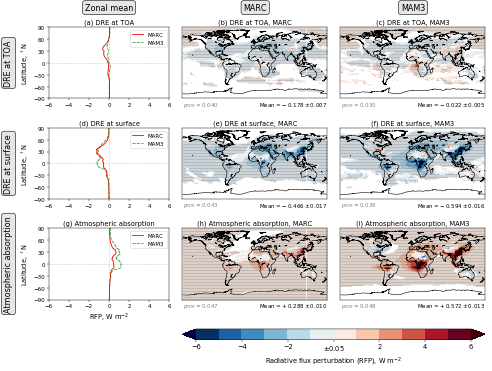

In [13]:
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(4, 3,  # 4th row is for colorbar
                       height_ratios=[1, 1, 1, 0.15], width_ratios=[2.5, 3, 3])
axs = []  # list to hold axes
tm_diff_list = []  # list to hold difference fields from maps - for colorbar extension choice
xlim = [-6, 6]  # x-axis and colorbar range
whiteout = '0.05'  # mask values with small magnitude
xticks = np.arange(-6, 7, 2)
# Loop over variables (rows)
for var_long, r in zip(['DRE at TOA', 'DRE at surface', 'Atmospheric absorption'], range(3)):
    # Variable names for different components
    if var_long == 'DRE at TOA':
        model_var_dict={'marc': 'cDRE', 'mam3': 'cDRE'}
    elif var_long == 'DRE at surface':
        model_var_dict={'marc': 'cDREsurf', 'mam3': 'cDREsurf'}
    elif var_long == 'Atmospheric absorption':
        model_var_dict={'marc': 'cDREatm', 'mam3': 'cDREatm'}
    # 1st column: zonal means
    ax = plt.subplot(gs[r, 0])
    axs.append(ax)
    if r == 2:  # add x-axis label to only final row
        xlabel = r'RFP, W m$^{-2}$'
    else:
        xlabel = None
    title = '({}) {}'.format(chr(97+r*3), var_long)
    zonal_mean_line_plot(year='2000-1850', model_var_dict=model_var_dict,
                         xlabel=xlabel, xlim=xlim,
                         ylabel=True, title=title, ax=ax)
    plt.xticks(xticks)
    # Row title
    ax.text(-10, 0, var_long,
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            rotation=90,
            bbox={'boxstyle': 'round', 'fc': '0.9', 'ec': 'k'})
    # 2nd & 3rd columns: maps
    for model, c in zip(['marc', 'mam3'], range(1, 3)):
        ax = plt.subplot(gs[r, c])
        axs.append(ax)
        title = '({}) {}, {}'.format(chr(97+r*3+c), var_long, model.upper())
        ax, im, tm_diff = difference_map(year='2000-1850', model=model, var_name=model_var_dict[model],
                                         vmin=xlim[0], vmax=xlim[1], whiteout=whiteout,
                                         title=title, ax=ax)
        tm_diff_list.append(tm_diff)
# Colorbar
tm_diff_max = max([tm_diff.max() for tm_diff in tm_diff_list])
tm_diff_min = min([tm_diff.min() for tm_diff in tm_diff_list])
if tm_diff_min < xlim[0] and tm_diff_max > xlim[1]:
    extend = 'both'
elif tm_diff_min < xlim[0]:
    extend = 'min'
elif tm_diff_max > xlim[1]:
    extend = 'max'
else:
    extend = 'neither'
cbar = fig.colorbar(im, cax=plt.subplot(gs[-1, 1:]), orientation='horizontal',
                    ticks=xticks, extend=extend)
tick_labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
tick_labels[3] = '$\pm$' + whiteout
cbar.ax.set_xticklabels(tick_labels, fontsize='large')
cbar.set_label(r'Radiative flux perturbation (RFP), W m$^{-2}$', fontsize='large')
# Column titles
for ax, title in zip(axs[0:3], ['Zonal mean', 'MARC', 'MAM3']):
    ax.text(0, 140, title,
            fontsize='x-large', verticalalignment='center', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save
fig.savefig('local/dre_zonal_means_and_maps.pdf', bbox_inches='tight', dpi=150)
fig.savefig('local/dre_zonal_means_and_maps.png', bbox_inches='tight', dpi=600)